# Altermagnetic superconductors

In [5]:
import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from amsc import impurity_system, bulk_amsc_system, generate_intial_Delta, setup_gaussian_impurities
from plot_tools import add_tl_label, complex_plot
from scipy.interpolate import RegularGridInterpolator
from tqdm.notebook import tqdm
from pauli import *
from qm_tools import thermal_broadening, sparse_diag, sort_eigensystem

In [6]:
eigsh = sla.eigsh
# eigsh = sparse_diag # MUMPS

In [7]:
plt.style.use("../plot_style.mplstyle")

# System Setup

In [8]:
periodic_bc = True

Nx = 81
Ny = 81

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 5.0
t_so = 0.0 * t
t_am = 0.25 * t

mu = 2.5 
hz0 = 1e-6
hx0 = 0
hy0 = 0

## Initial value for Delta (will be used to determine g)
Delta_init = 1

In [9]:
vortex_positions = []
windings = []  
l_core = 0  # l_core is the decay length of the order parameter (in a vortex that is the coherence length)

Delta, theta = generate_intial_Delta(
    x = x, 
    y = y, 
    Delta_init= Delta_init,
    vortex_positions=vortex_positions, 
    windings=windings,
    l_core=l_core
)

In [10]:
# Impurituy positions
impurity_positions = [(0, 0), (0, 0)]  # , (-10, 0)]
impurity_sizes = [1.8, 1.8]  # Sizes
impurity_eccentricities = [0.0, 0.0]  # Eccentricity
impurity_orientation = [0.0, 0.0]  # Orientation


V_imp = [-20, -20]  # Impurity potential (negative = attractive)
hx_imp = [0.0, 0.0]  # Impurity field
hy_imp = [0.0, 0.0]  # Impurity field
hz_imp = [0.0, 0.0]  # Impurity field

In [11]:
N = 100

In [30]:
ds = np.arange(24, 4, -1)
P = len(ds)

wss = np.zeros((P, N))
vss = np.zeros((P, 4*Nx**2, N), dtype=complex)

for i, d in tqdm(enumerate(ds), total=len(ds)):
    
    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=impurity_sizes,
        impurity_positions= [(0.0, 0.0), (0.0, +d)],
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=V_imp,
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
        )
    
    fsyst = syst.finalized()
    
    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0) 

    wss[i] = ws
    vss[i] = vs

  0%|          | 0/20 [00:00<?, ?it/s]

In [31]:
wss_ordered = wss[:].copy()
vss_ordered = vss[:].copy()

sort_idx = wss_ordered[0].argsort()
wss_ordered[0] = wss_ordered[0, sort_idx]
vss_ordered[0, :] = vss_ordered[0, :, sort_idx].T

In [32]:
wss_sp, vss_sp = sort_eigensystem(wss_ordered, vss_ordered)
wss_ordered = wss_sp
vss_ordered = vss_sp

In [33]:
idxs = (-1/(wss_ordered[0])).argsort()

In [34]:
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

In [40]:
idxp = np.argwhere(ds==11)[0][0]

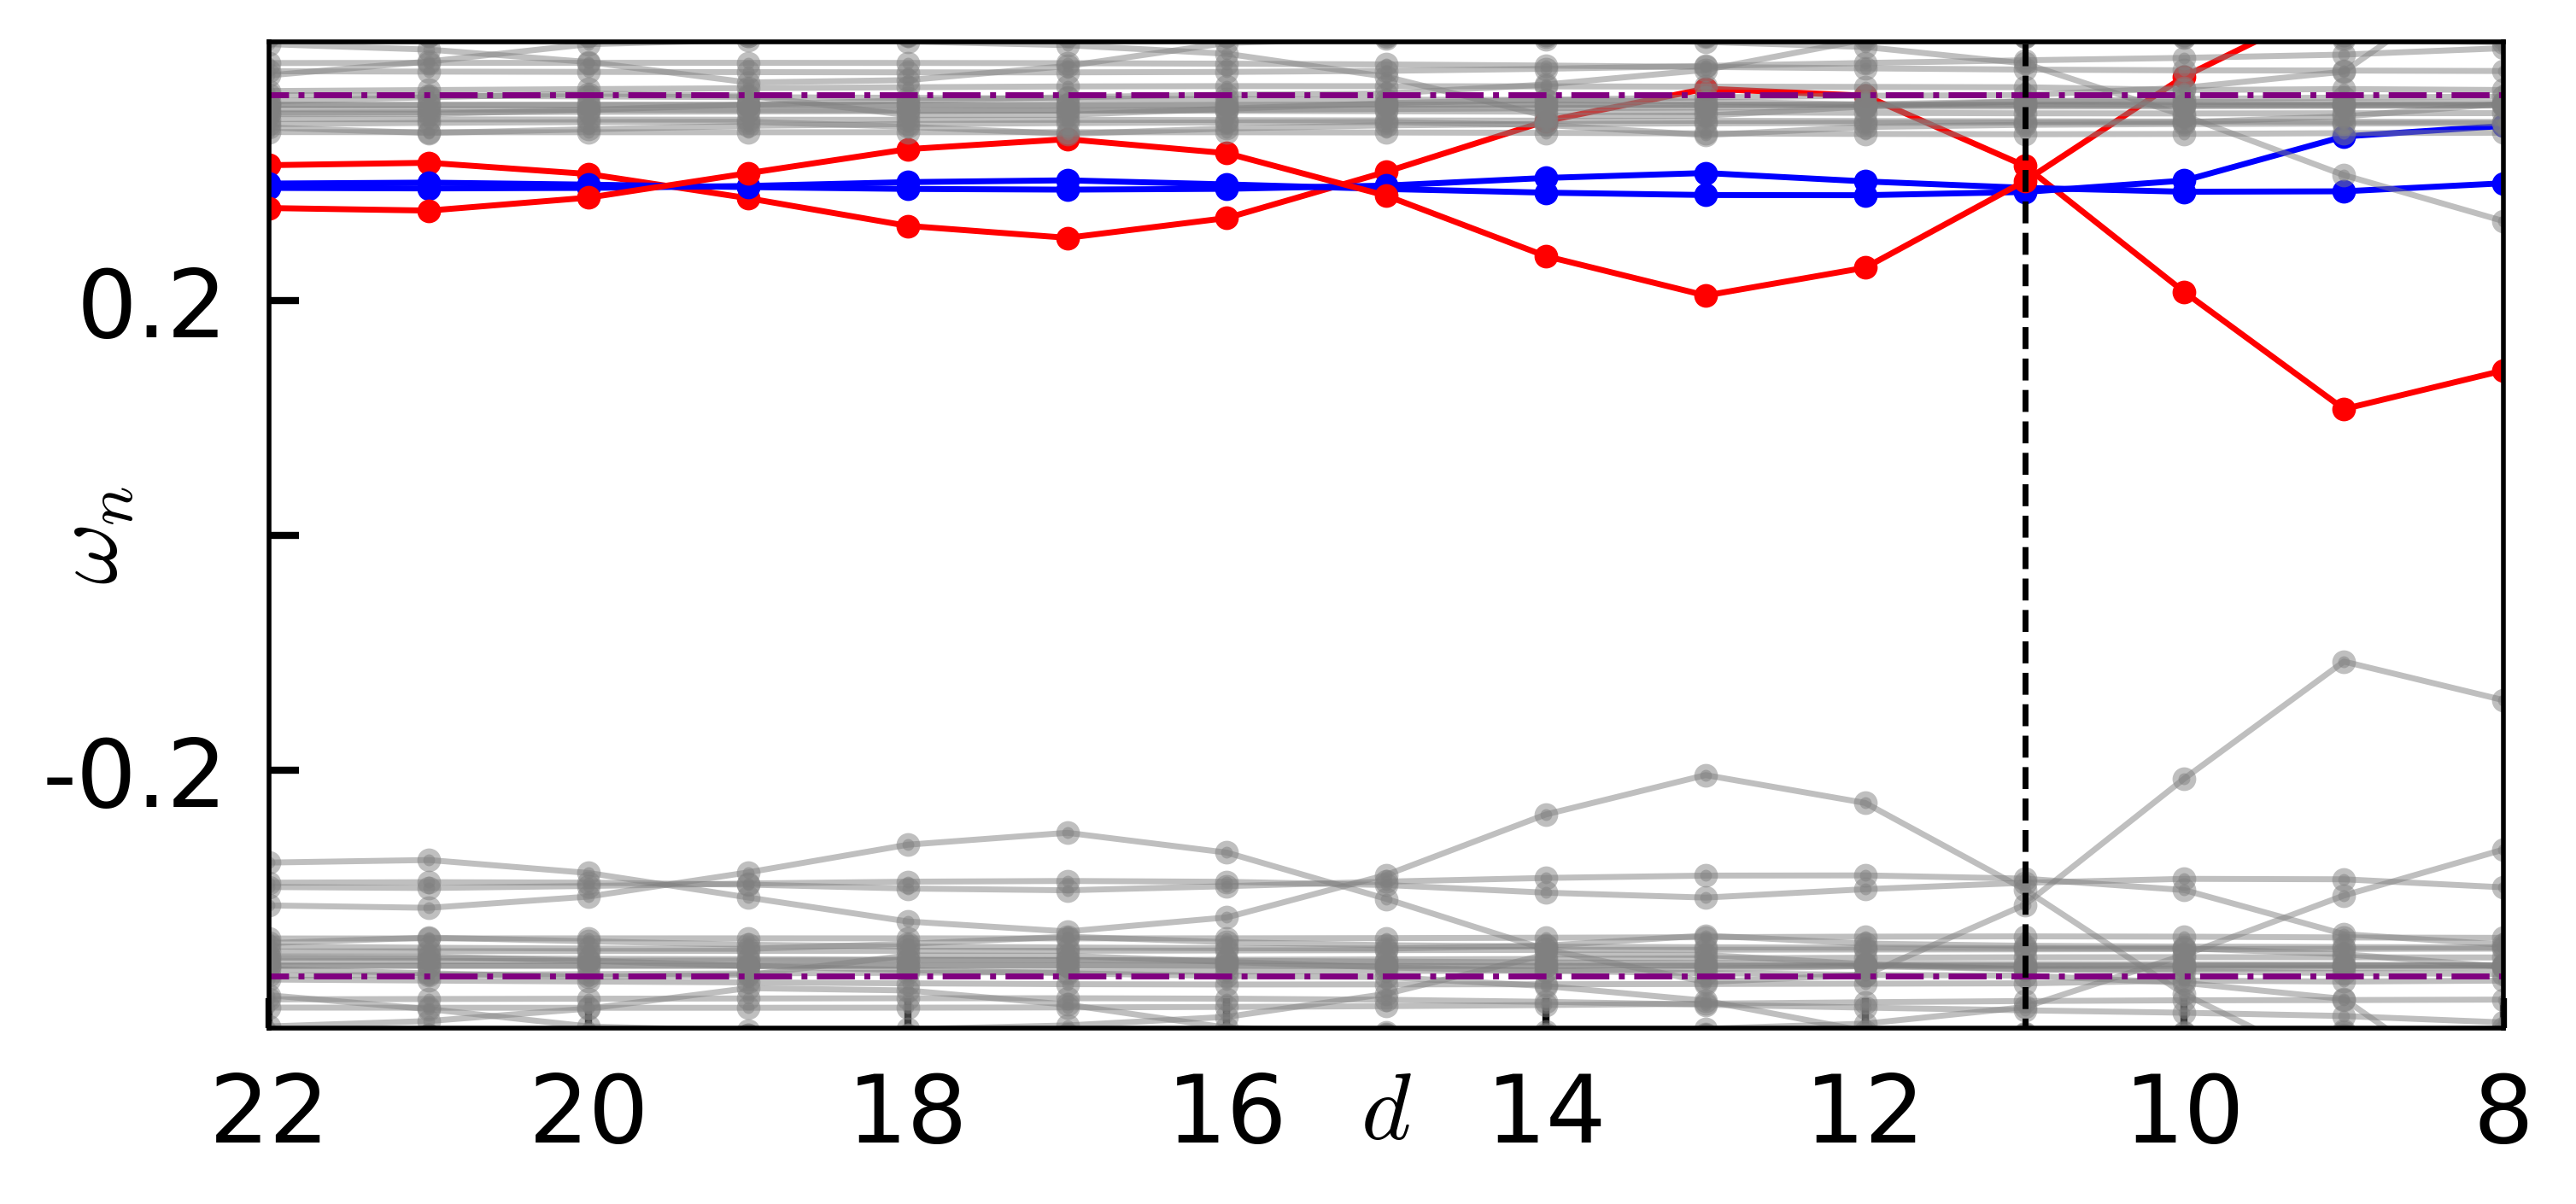

In [49]:
colors=np.zeros((N, 4))
colors[:] = (0.5, 0.5, 0.5, 0.5)

for p in range(4):
    colors[idxs[p], :] = (1, 0, 0, 1) if np.round(t0sz_op(vss_ordered[P//2+1, :, idxs[p]]).sum()) > 0 else (0, 0, 1, 1)


fig, ax = plt.subplots(figsize=(3.375, 1.5))

for i in range(N):
    ax.plot(ds[:], wss_ordered[:, i], linestyle='-', marker='.', color=colors[i])


ax.plot(ds, Delta_init - mu * t_am/t + 0*ds, '-.', color='purple')
ax.plot(ds, -Delta_init + mu * t_am/t + 0*ds, '-.', color='purple')

ax.vlines(ds[idxp], -0.43, 0.43, colors="k", linestyles='--')

#ax.set_xticks([-0.2, 0, 0.2], labels=["-0.2", "", "0.2"])
ax.set_yticks([-0.2, 0, 0.2], labels=["-0.2", "", "0.2"])

ax.set_xlabel(r"$d$", labelpad = -8)
ax.set_ylabel(r"$\omega_n$", labelpad=-8)
ax.set_ylim(-0.42, 0.42)
ax.set_xlim(22, 8)

fig.savefig("Fig3_plot.svg")

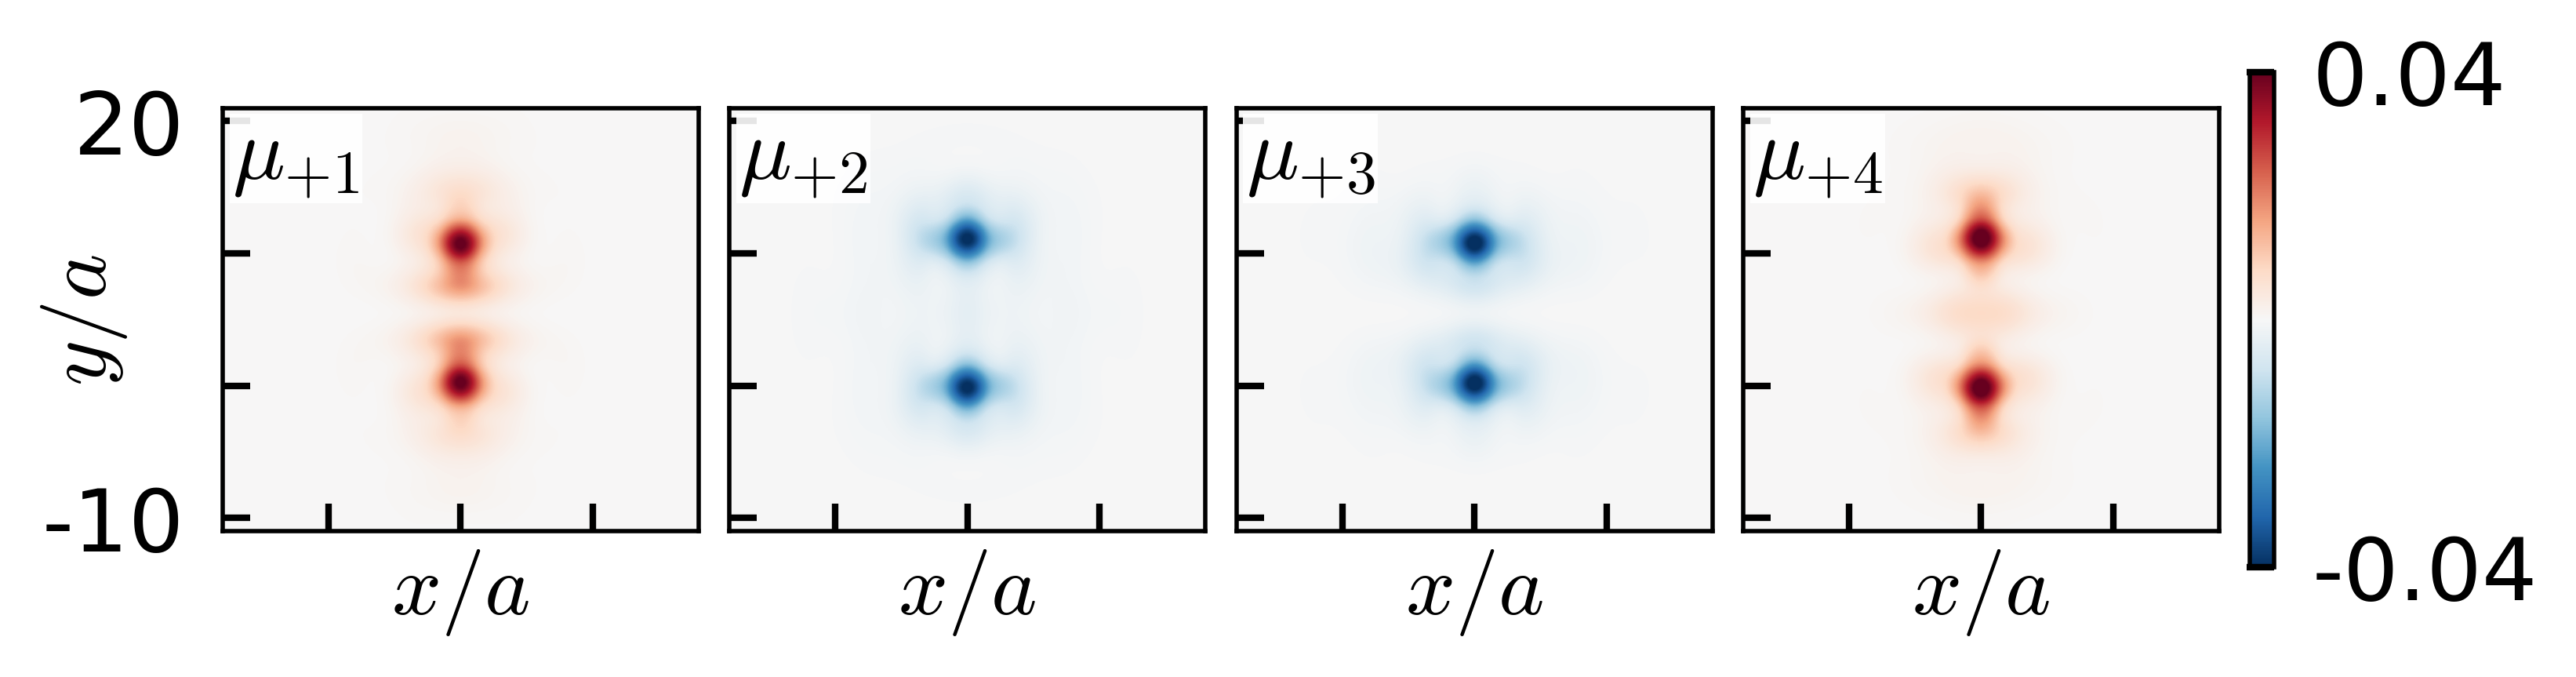

In [55]:
d_1 = t0s0_op(vss_ordered[idxp, :, idxs[0]])
d_2 = t0s0_op(vss_ordered[idxp, :, idxs[1]])
d_3 = t0s0_op(vss_ordered[idxp, :, idxs[2]])
d_4 = t0s0_op(vss_ordered[idxp, :, idxs[3]])

m_1 = t0sz_op(vss_ordered[idxp, :, idxs[0]])
m_2 = t0sz_op(vss_ordered[idxp, :, idxs[1]])
m_3 = t0sz_op(vss_ordered[idxp, :, idxs[2]])
m_4 = t0sz_op(vss_ordered[idxp, :, idxs[3]])


# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 0.82))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)


# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4]) 

# # Determine color limits
# vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))
# vmin = 0

# im1d = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap="Grays", vmin=vmin, vmax=vmax)
# im2d = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap="Grays", vmin=vmin, vmax=vmax)
# im3d = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap="Grays", vmin=vmin, vmax=vmax)
# im4d = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap="Grays", vmin=vmin, vmax=vmax)

# Determine color limits
vmax = np.max(np.abs([m_1, m_2, m_3, m_4]))
vmin = -vmax

# Plot densities with kwant.plotter.density
im1m = kwant.plotter.density(fsyst, m_1, ax=ax1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im2m = kwant.plotter.density(fsyst, m_2, ax=ax2, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im3m = kwant.plotter.density(fsyst, m_3, ax=ax3, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im4m = kwant.plotter.density(fsyst, m_4, ax=ax4, cmap="RdBu_r", vmin=vmin, vmax=vmax)


# for ax in [ax1, ax2, ax3, ax4]:
#     ax.images[0].set_alpha(0.5)
#     ax.images[1].set_alpha(0.5)

# Set lims
xlims = (-18, 18)
ylims = (-11, 21)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10, 20], labels=['-10', "", "", "20"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-10, 0, 10, 20], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-10, 0, 10], labels=[])#labels=["-20", "", "20"])


ax1.set_ylabel(r"$y/a$", labelpad = -8)
ax1.set_xlabel(r"$x/a$", labelpad = -2)
ax2.set_xlabel(r"$x/a$", labelpad = -2)
ax3.set_xlabel(r"$x/a$", labelpad = -2)
ax4.set_xlabel(r"$x/a$", labelpad = -2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)

# Add titles for each subplot
add_tl_label(ax1, r'$\mu_{+1}$')
add_tl_label(ax2, r'$\mu_{+2}$')
add_tl_label(ax3, r'$\mu_{+3}$')
add_tl_label(ax4, r'$\mu_{+4}$')

# Create a common colorbar on the right
#fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap="RdBu_r")
cbar.set_ticks([vmin, vmax], labels= [f'{vmin:.2f}', f'{vmax:.2f}'])

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])

# Save the figure as SVG with rasterized content
plt.savefig("Fig3_insets.svg", format="svg", dpi=300)

## Angle

In [28]:
d = 15

In [29]:
phis = np.linspace(0, np.pi, 17)

In [30]:
P = len(phis)

wss = np.zeros((P, N))
vss = np.zeros((P, 4*Nx**2, N), dtype=complex)

for i, phi in tqdm(enumerate(phis), total=len(phis)):
    
    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=impurity_sizes,
        impurity_positions= [(0.0, 0.0), ( np.around(d * np.sin(phi)), np.around(d * np.cos(phi)))],
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=V_imp,
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
        )
    
    fsyst = syst.finalized()
    
    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0) 

    wss[i] = ws
    vss[i] = vs

  0%|          | 0/17 [00:00<?, ?it/s]

In [31]:
wss_ordered = wss[:].copy()
vss_ordered = vss[:].copy()

sort_idx = wss_ordered[0].argsort()
wss_ordered[0] = wss_ordered[0, sort_idx]
vss_ordered[0, :] = vss_ordered[0, :, sort_idx].T

In [32]:
wss_sp, vss_sp = sort_eigensystem(wss_ordered, vss_ordered)
wss_ordered = wss_sp
vss_ordered = vss_sp

In [33]:
idxs = (-1/(wss_ordered[0])).argsort()

In [34]:
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

In [35]:
idxp = 0

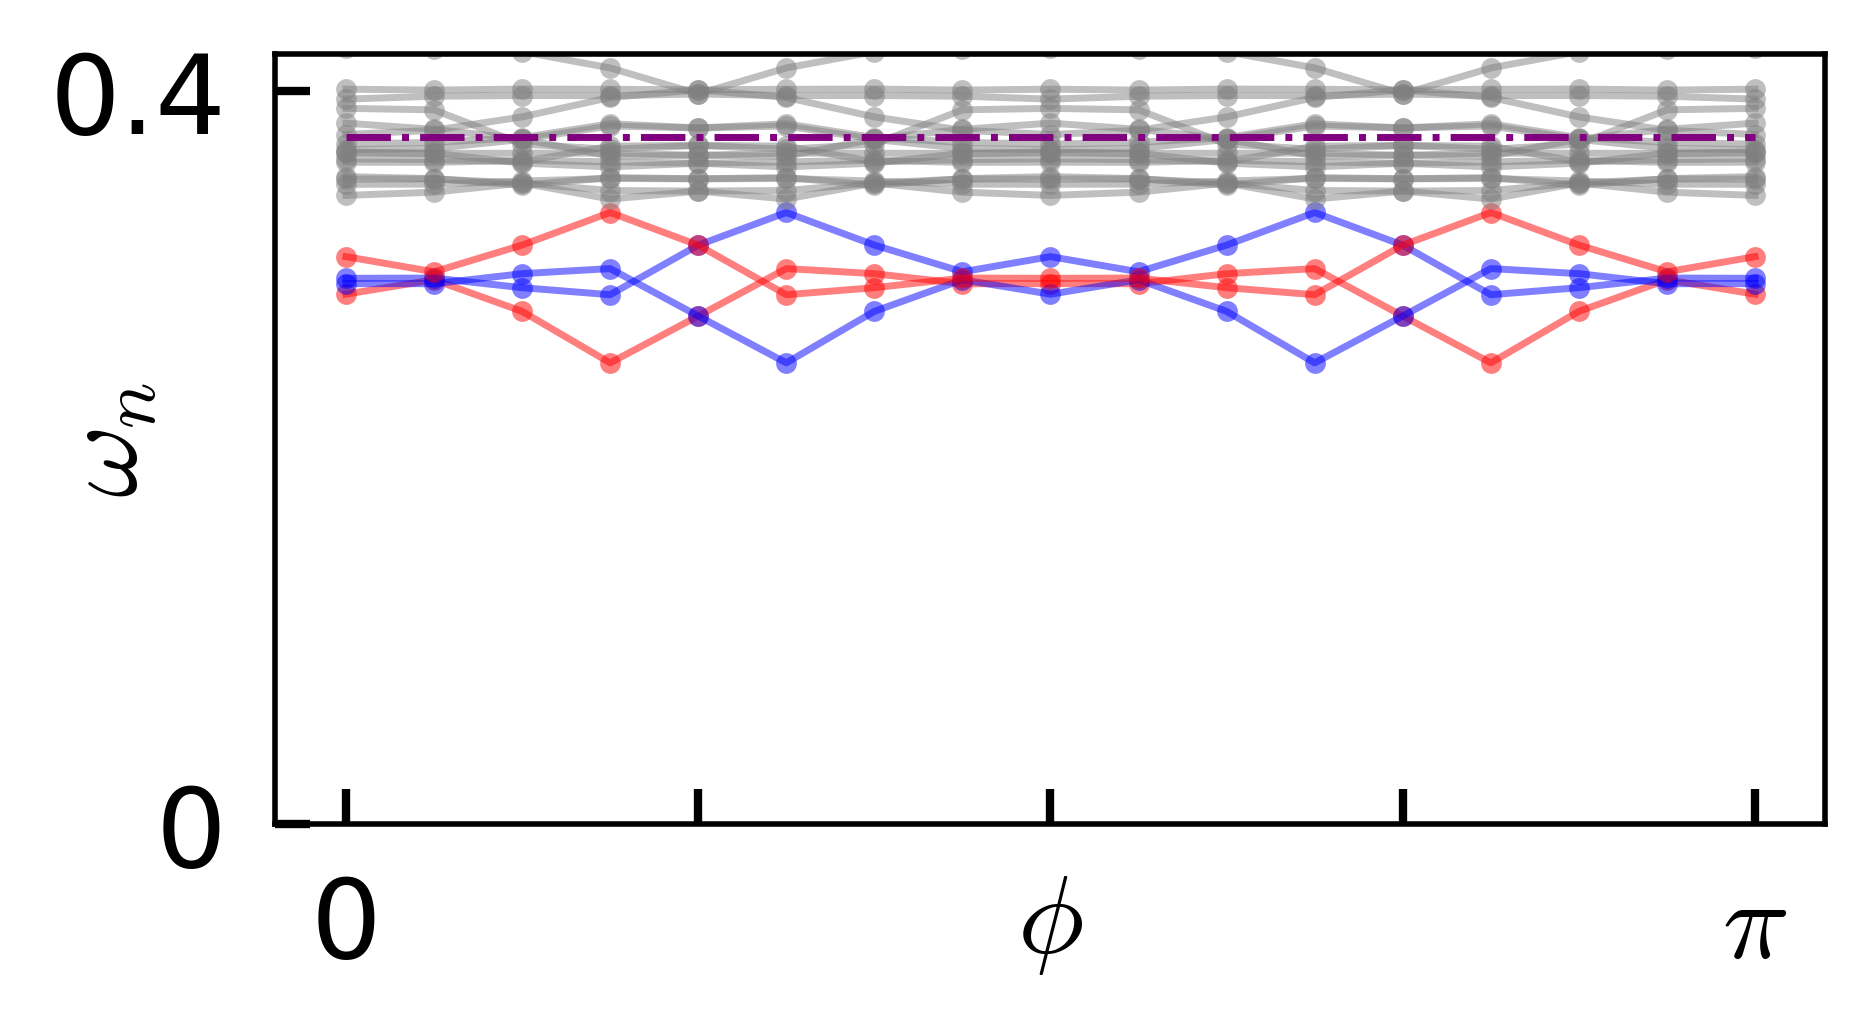

In [45]:
colors=np.zeros((N, 4))
colors[:] = (0.5, 0.5, 0.5, 0.5)

for p in range(4):
    colors[idxs[p], :] = (1, 0, 0, 1) if np.round(t0sz_op(vss_ordered[P//2+1, :, idxs[p]]).sum()) > 0 else (0, 0, 1, 1)


fig, ax = plt.subplots(figsize=(2, 1.0))

for i in range(N):
    ax.plot(phis/np.pi, wss_ordered[:, i], linestyle='-', marker='.', markersize=1, color=colors[i], alpha=0.5)


ax.plot(phis/np.pi, Delta_init - mu * t_am/t + 0*phis/np.pi, '-.', color='purple')
ax.plot(phis/np.pi, -Delta_init + mu * t_am/t + 0*phis/np.pi, '-.', color='purple')



ax.set_xticks([0, 0.25, 0.5, 0.75,  1], labels=["0", "", "", "", r"$\pi$"])
ax.set_yticks([0, 0.4], labels=["0", "0.4"])

ax.set_xlabel(r"$\phi$", labelpad = -8)
ax.set_ylabel(r"$\omega_n$", labelpad=-8)
ax.set_ylim(0, 0.42)
# ax.set_xlim(22, 8)

fig.savefig("Fig3_up_plot.svg")

In [39]:
idxp=0

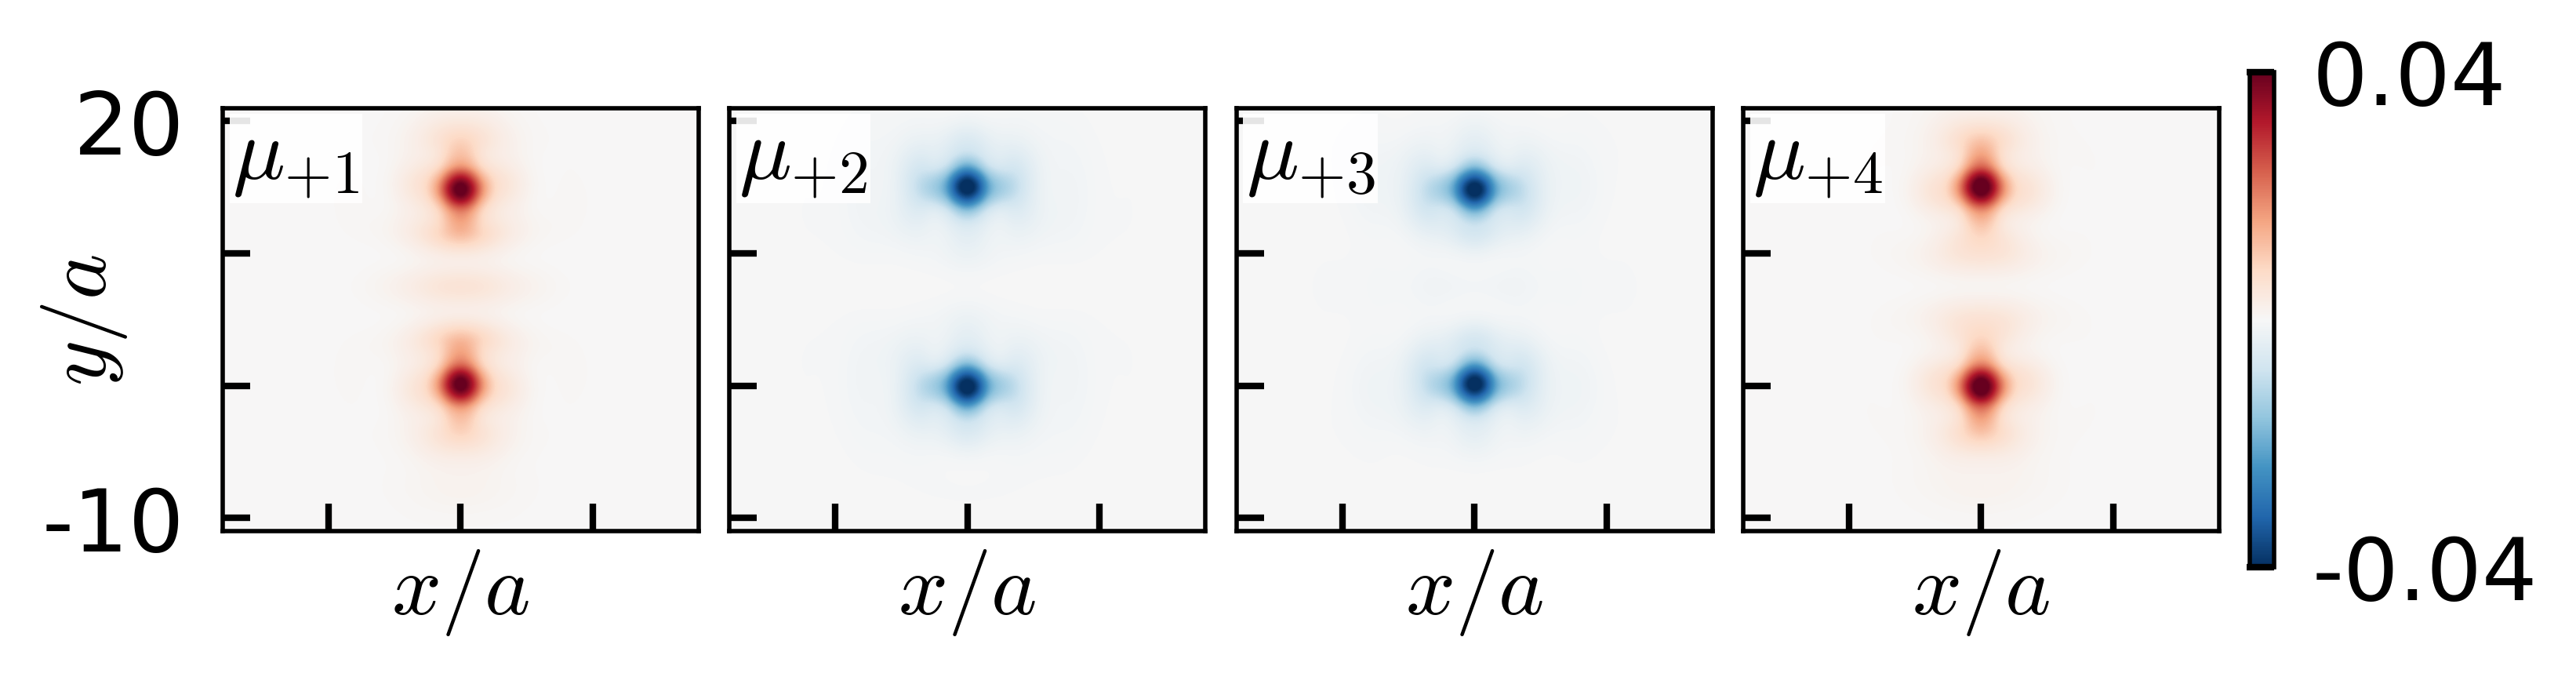

In [40]:
d_1 = t0s0_op(vss_ordered[idxp, :, idxs[0]])
d_2 = t0s0_op(vss_ordered[idxp, :, idxs[1]])
d_3 = t0s0_op(vss_ordered[idxp, :, idxs[2]])
d_4 = t0s0_op(vss_ordered[idxp, :, idxs[3]])

m_1 = t0sz_op(vss_ordered[idxp, :, idxs[0]])
m_2 = t0sz_op(vss_ordered[idxp, :, idxs[1]])
m_3 = t0sz_op(vss_ordered[idxp, :, idxs[2]])
m_4 = t0sz_op(vss_ordered[idxp, :, idxs[3]])


# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 0.82))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)


# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4]) 

# # Determine color limits
# vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))
# vmin = 0

# im1d = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap="Grays", vmin=vmin, vmax=vmax)
# im2d = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap="Grays", vmin=vmin, vmax=vmax)
# im3d = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap="Grays", vmin=vmin, vmax=vmax)
# im4d = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap="Grays", vmin=vmin, vmax=vmax)

# Determine color limits
vmax = np.max(np.abs([m_1, m_2, m_3, m_4]))
vmin = -vmax

# Plot densities with kwant.plotter.density
im1m = kwant.plotter.density(fsyst, m_1, ax=ax1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im2m = kwant.plotter.density(fsyst, m_2, ax=ax2, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im3m = kwant.plotter.density(fsyst, m_3, ax=ax3, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im4m = kwant.plotter.density(fsyst, m_4, ax=ax4, cmap="RdBu_r", vmin=vmin, vmax=vmax)


# for ax in [ax1, ax2, ax3, ax4]:
#     ax.images[0].set_alpha(0.5)
#     ax.images[1].set_alpha(0.5)

# Set lims
xlims = (-18, 18)
ylims = (-11, 21)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10, 20], labels=['-10', "", "", "20"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-10, 0, 10, 20], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-10, 0, 10], labels=[])#labels=["-20", "", "20"])


ax1.set_ylabel(r"$y/a$", labelpad = -8)
ax1.set_xlabel(r"$x/a$", labelpad = -2)
ax2.set_xlabel(r"$x/a$", labelpad = -2)
ax3.set_xlabel(r"$x/a$", labelpad = -2)
ax4.set_xlabel(r"$x/a$", labelpad = -2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)

# Add titles for each subplot
add_tl_label(ax1, r'$\mu_{+1}$')
add_tl_label(ax2, r'$\mu_{+2}$')
add_tl_label(ax3, r'$\mu_{+3}$')
add_tl_label(ax4, r'$\mu_{+4}$')

# Create a common colorbar on the right
#fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap="RdBu_r")
cbar.set_ticks([vmin, vmax], labels= [f'{vmin:.2f}', f'{vmax:.2f}'])

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])

# Save the figure as SVG with rasterized content
# plt.savefig("Fig3_insets.svg", format="svg", dpi=300)

## Bz field

In [27]:
d = 15
bs = np.linspace(0, 0.35, 9)

P = len(bs)

wss = np.zeros((P, N))
vss = np.zeros((P, 4*Nx**2, N), dtype=complex)

for i, bz in tqdm(enumerate(bs), total=len(bs)):
    
    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=bz,
        impurity_sizes=impurity_sizes,
        impurity_positions= [(0.0, 0.0), (0.0, d)],
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=V_imp,
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
        )
    
    fsyst = syst.finalized()
    
    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0) 

    wss[i] = ws
    vss[i] = vs

  0%|          | 0/9 [00:00<?, ?it/s]

In [28]:
wss_ordered = wss[:].copy()
vss_ordered = vss[:].copy()

sort_idx = wss_ordered[0].argsort()
wss_ordered[0] = wss_ordered[0, sort_idx]
vss_ordered[0, :] = vss_ordered[0, :, sort_idx].T

In [29]:
wss_sp, vss_sp = sort_eigensystem(wss_ordered, vss_ordered)
wss_ordered = wss_sp
vss_ordered = vss_sp

In [30]:
idxs = (-1/(wss_ordered[0])).argsort()

In [31]:
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

In [32]:
idxp = 0

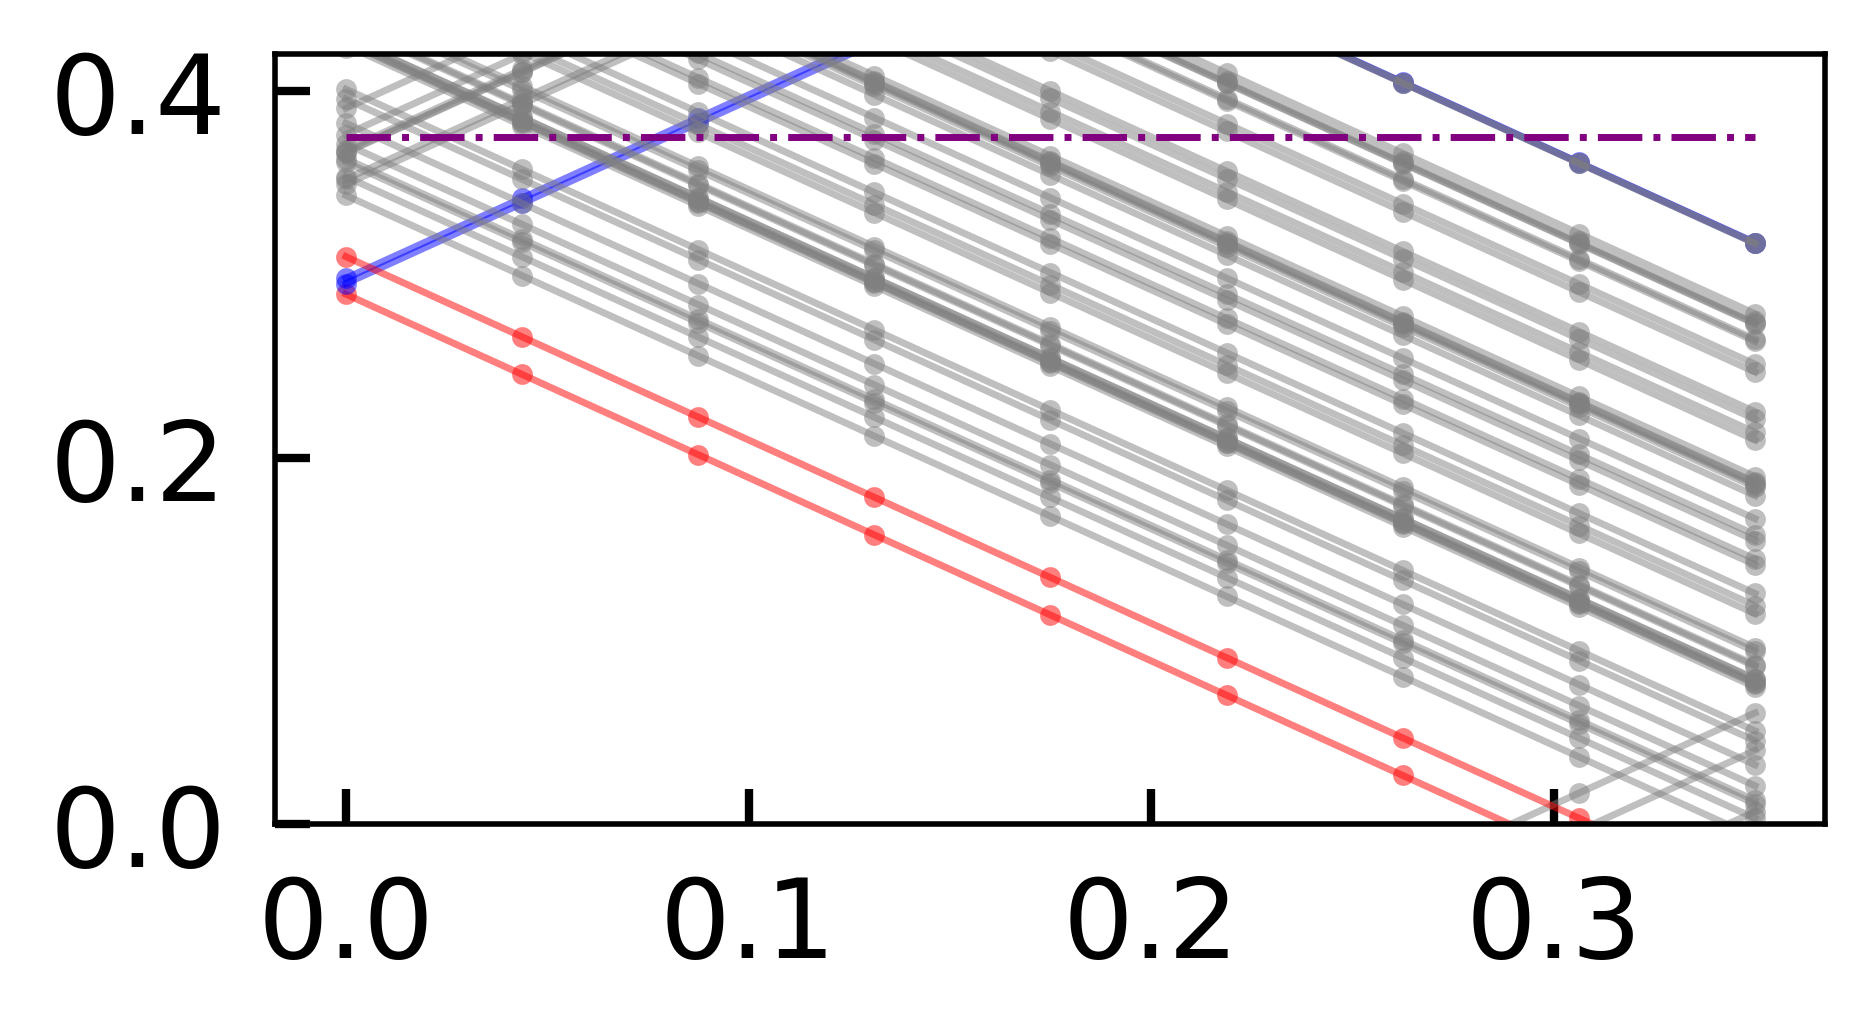

In [33]:
colors=np.zeros((N, 4))
colors[:] = (0.5, 0.5, 0.5, 0.5)

for p in range(4):
    colors[idxs[p], :] = (1, 0, 0, 1) if np.round(t0sz_op(vss_ordered[P//2, :, idxs[p]]).sum()) > 0 else (0, 0, 1, 1)


fig, ax = plt.subplots(figsize=(2, 1.0))

for i in range(N):
    ax.plot(bs, wss_ordered[:, i], linestyle='-', marker='.', markersize=1, color=colors[i], alpha=0.5)


ax.plot(bs, Delta_init - mu * t_am/t + 0*bs/np.pi, '-.', color='purple')
ax.plot(bs, -Delta_init + mu * t_am/t + 0*bs/np.pi, '-.', color='purple')



# ax.set_xticks([0, 0.25, 0.5, 0.75,  1], labels=["0", "", "", "", r"$\pi$"])
# ax.set_yticks([0, 0.4], labels=["0", "0.4"])

# ax.set_xlabel(r"$\phi$", labelpad = -8)
# ax.set_ylabel(r"$\omega_n$", labelpad=-8)
ax.set_ylim(0, 0.42)
# ax.set_xlim(22, 8)

fig.savefig("Fig3_bottom_plot.svg")

## Bx field

In [107]:
d = 15
bs = np.linspace(0, 0.35, 21)

P = len(bs)

wss = np.zeros((P, N))
vss = np.zeros((P, 4*Nx**2, N), dtype=complex)

for i, bz in tqdm(enumerate(bs), total=len(bs)):
    
    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=bz,
        impurity_sizes=impurity_sizes,
        impurity_positions= [(0.0, 0.0), (0.0, d)],
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=V_imp,
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so= 0.01 * t,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
        )
    
    fsyst = syst.finalized()
    
    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0) 

    wss[i] = ws
    vss[i] = vs

  0%|          | 0/21 [00:00<?, ?it/s]

In [114]:
wss_ordered = wss[:].copy()
vss_ordered = vss[:].copy()

sort_idx = wss_ordered[0].argsort()
wss_ordered[0] = wss_ordered[0, sort_idx]
vss_ordered[0, :] = vss_ordered[0, :, sort_idx].T

In [115]:
wss_sp, vss_sp = sort_eigensystem(wss_ordered, vss_ordered)
wss_ordered = wss_sp
vss_ordered = vss_sp

In [116]:
idxs = (-1/(wss_ordered[0])).argsort()

In [117]:
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

In [118]:
idxp = 0

In [123]:
szs = np.zeros((P, 4))

for n in range(4):
    for p in range(P):
        szs[p, n] = t0sz_op(vss_ordered[p, :, idxs[n]]).sum()

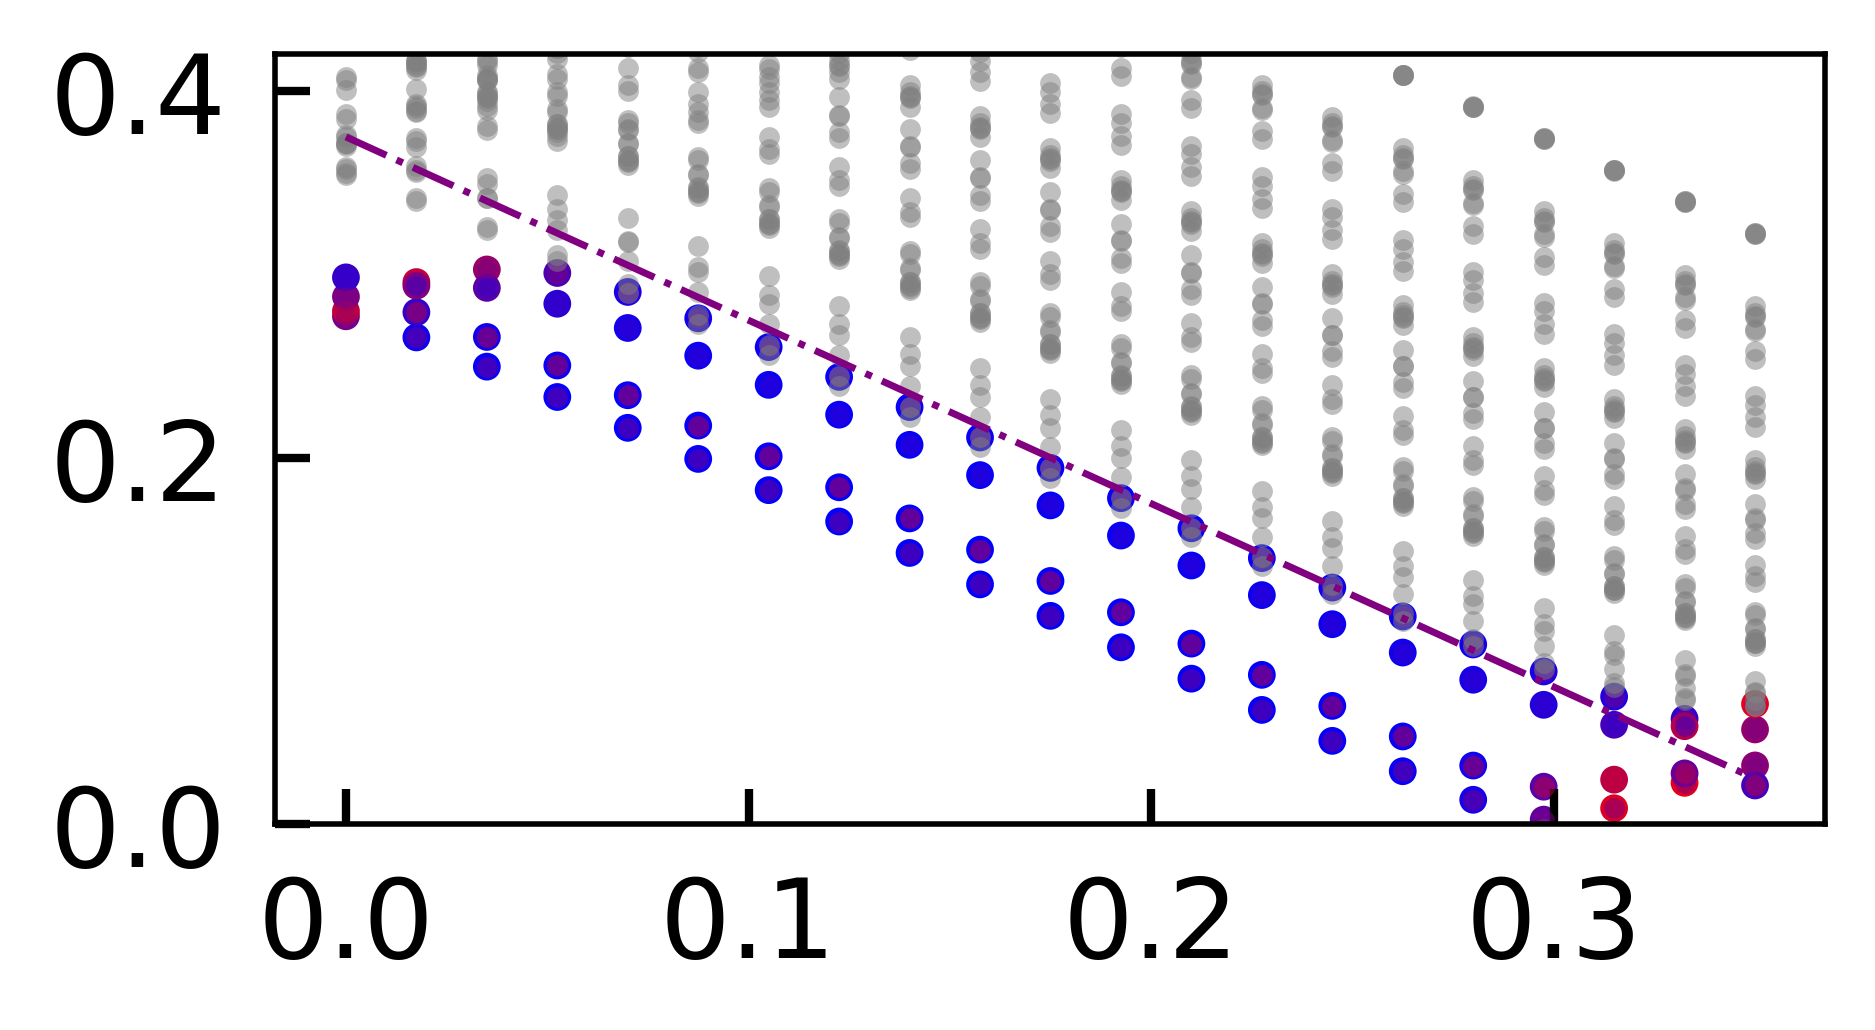

In [129]:
colors=np.zeros((P, N, 4))
colors[:] = (0.5, 0.5, 0.5, 0.5)

for p in range(P):
    for n in range(4):
        colors[p, idxs[n], :] = ((1-szs[p, n])/2, 0, (+1+szs[p, n])/2, 1)

fig, ax = plt.subplots(figsize=(2, 1.0))

for i in range(N):
    ax.plot(bs, wss_ordered[:, i], linestyle='', marker='.', markersize=1, color=colors[0, i], alpha=0.5)

for n in range(4):
    ax.scatter(bs, wss_ordered[:, idxs[n]], marker='.', color=colors[:, idxs[n]], alpha=1)



ax.plot(bs, Delta_init - mu * t_am/t - bs, '-.', color='purple')
ax.plot(bs, -Delta_init + mu * t_am/t + bs, '-.', color='purple')



# ax.set_xticks([0, 0.25, 0.5, 0.75,  1], labels=["0", "", "", "", r"$\pi$"])
# ax.set_yticks([0, 0.4], labels=["0", "0.4"])

# ax.set_xlabel(r"$\phi$", labelpad = -8)
# ax.set_ylabel(r"$\omega_n$", labelpad=-8)
ax.set_ylim(0, 0.42)
# ax.set_xlim(22, 8)

fig.savefig("Fig3_bottom_plot.svg")

In [102]:
idxp = 0

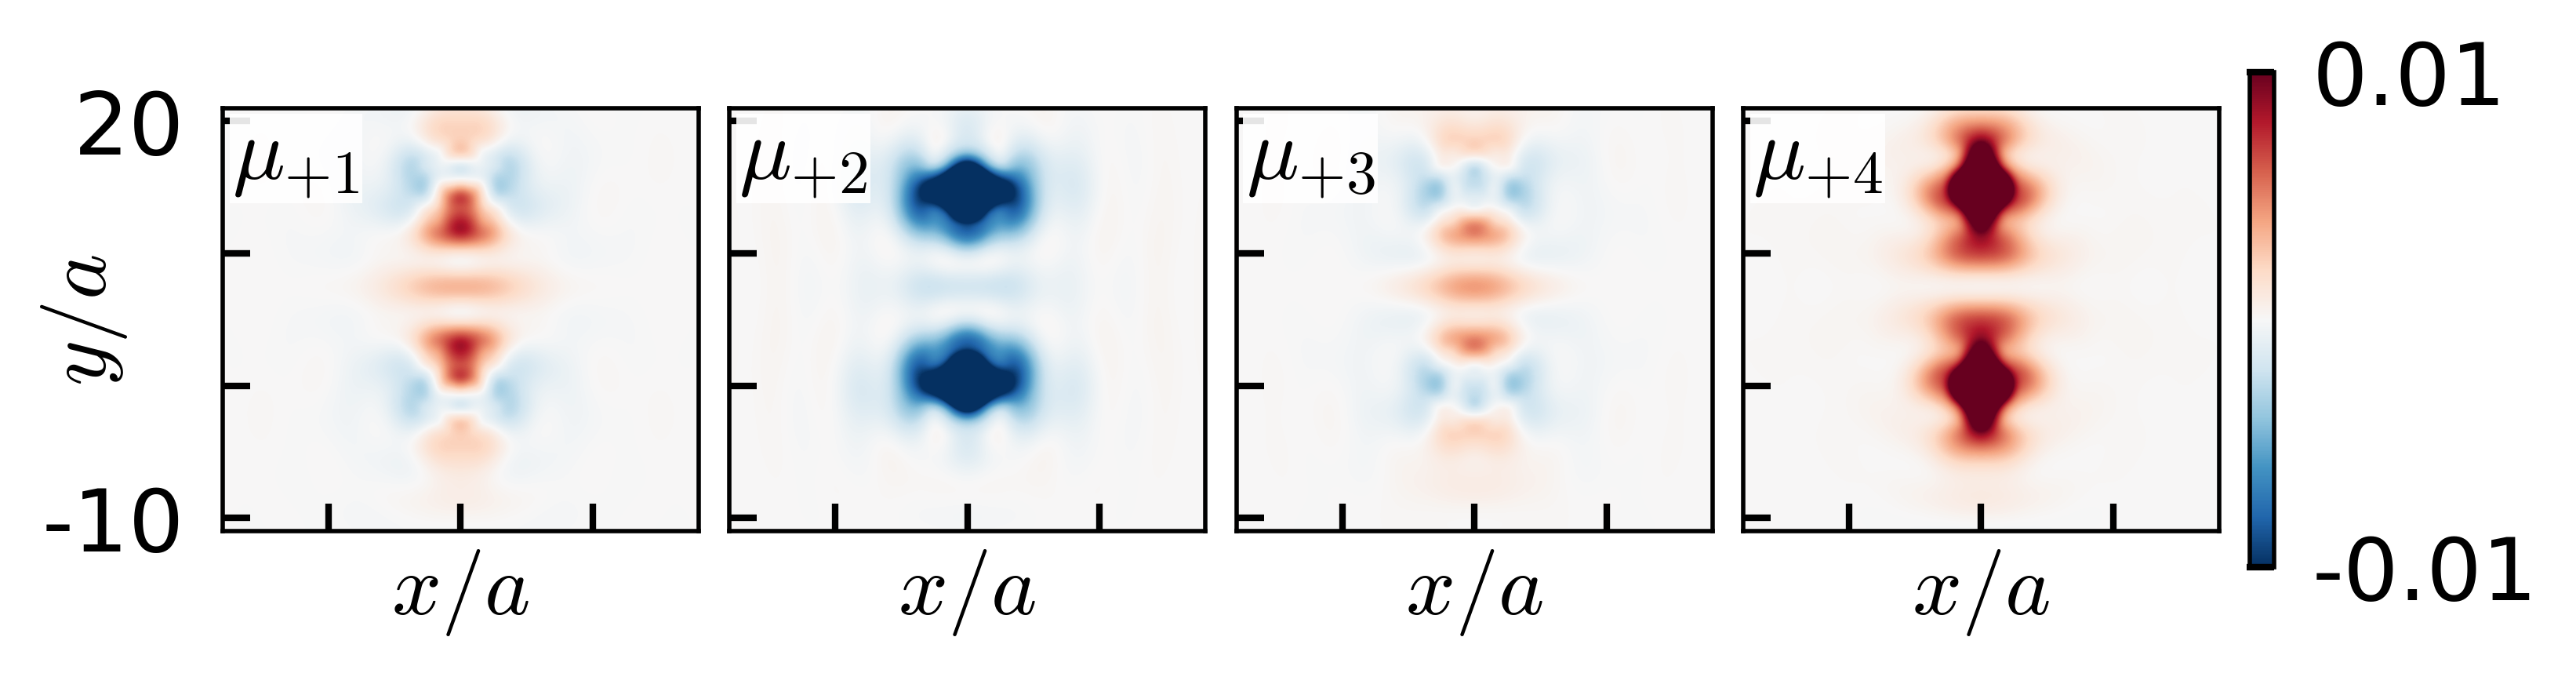

In [103]:
d_1 = t0s0_op(vss_ordered[idxp, :, idxs[0]])
d_2 = t0s0_op(vss_ordered[idxp, :, idxs[1]])
d_3 = t0s0_op(vss_ordered[idxp, :, idxs[2]])
d_4 = t0s0_op(vss_ordered[idxp, :, idxs[3]])

m_1 = t0sz_op(vss_ordered[idxp, :, idxs[0]])
m_2 = t0sz_op(vss_ordered[idxp, :, idxs[1]])
m_3 = t0sz_op(vss_ordered[idxp, :, idxs[2]])
m_4 = t0sz_op(vss_ordered[idxp, :, idxs[3]])


# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 0.82))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)


# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4]) 

# # Determine color limits
# vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))
# vmin = 0

# im1d = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap="Grays", vmin=vmin, vmax=vmax)
# im2d = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap="Grays", vmin=vmin, vmax=vmax)
# im3d = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap="Grays", vmin=vmin, vmax=vmax)
# im4d = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap="Grays", vmin=vmin, vmax=vmax)

# Determine color limits
vmax = np.max(np.abs([m_1, m_2, m_3, m_4]))/4
vmin = -vmax

# Plot densities with kwant.plotter.density
im1m = kwant.plotter.density(fsyst, m_1, ax=ax1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im2m = kwant.plotter.density(fsyst, m_2, ax=ax2, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im3m = kwant.plotter.density(fsyst, m_3, ax=ax3, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im4m = kwant.plotter.density(fsyst, m_4, ax=ax4, cmap="RdBu_r", vmin=vmin, vmax=vmax)


# for ax in [ax1, ax2, ax3, ax4]:
#     ax.images[0].set_alpha(0.5)
#     ax.images[1].set_alpha(0.5)

# Set lims
xlims = (-18, 18)
ylims = (-11, 21)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10, 20], labels=['-10', "", "", "20"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-10, 0, 10, 20], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-10, 0, 10], labels=[])#labels=["-20", "", "20"])


ax1.set_ylabel(r"$y/a$", labelpad = -8)
ax1.set_xlabel(r"$x/a$", labelpad = -2)
ax2.set_xlabel(r"$x/a$", labelpad = -2)
ax3.set_xlabel(r"$x/a$", labelpad = -2)
ax4.set_xlabel(r"$x/a$", labelpad = -2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)

# Add titles for each subplot
add_tl_label(ax1, r'$\mu_{+1}$')
add_tl_label(ax2, r'$\mu_{+2}$')
add_tl_label(ax3, r'$\mu_{+3}$')
add_tl_label(ax4, r'$\mu_{+4}$')

# Create a common colorbar on the right
#fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap="RdBu_r")
cbar.set_ticks([vmin, vmax], labels= [f'{vmin:.2f}', f'{vmax:.2f}'])

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])

# Save the figure as SVG with rasterized content
# plt.savefig("Fig3_insets.svg", format="svg", dpi=300)